In [109]:
# We import the libreries we'll need

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
import lightgbm as lgb

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [110]:
# Get the current working directory
current_directory = os.getcwd()

# Specify the path to the CSV file relative to the current directory
contract_path = os.path.join(current_directory, '..', 'data', 'contract.csv')
personal_path = os.path.join(current_directory, '..', 'data', 'personal.csv')
internet_path = os.path.join(current_directory, '..', 'data', 'internet.csv')
phone_path = os.path.join(current_directory, '..', 'data', 'phone.csv')

# Load the datasets
contract = pd.read_csv(contract_path)
personal = pd.read_csv(personal_path)
internet = pd.read_csv(internet_path)
phone = pd.read_csv(phone_path)

## EDA

In [111]:
# We print the shape of all datasets 

datasets = [contract,personal,internet,phone]
for i in datasets:
    print(i.shape)

(7043, 8)
(7043, 5)
(5517, 8)
(6361, 2)


In [112]:
#  We print the columns of each dataset to understand how they are intertwined and what data each set will provide us

for i in datasets:
    print(i.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
Index(['customerID', 'MultipleLines'], dtype='object')


In [113]:
# We lowercase column names for better handling.

for i in datasets:
    i.columns = [j.lower() for j in i.columns]
    print(i.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')
Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')
Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')
Index(['customerid', 'multiplelines'], dtype='object')


In [114]:
# We check for duplicated values on each dataset

for i in datasets:
    print(i.customerid.duplicated().sum())

0
0
0
0


**Initial Observations**

We have noticed that we have datasets with varying numbers of observations. The **contract** and **personal** datasets each have 7043 observations, while the **internet** and **phone** datasets have 5517 and 6361 observations, respectively. We will investigate if the contract and personal datasets have the same observations using the `customerID` column. Similarly, we will examine the amount of missing data in the dataset with fewer observations.

In [115]:
# Check that we have the same observations in the contract and personal datasets.

set(contract['customerid']) - set(personal['customerid'])

set()

In [116]:
# We analyze the amount of missing observations between the contract dataset and the dataset with the fewest observations.

len(set(contract['customerid']) - set(internet['customerid']))

1526

In [117]:
# We analyze the percentage of missing data in the internet dataset compared to the contract dataset.

'{:.2%}'.format(len(set(contract['customerid']) - set(internet['customerid'])) / contract.shape[0])

'21.67%'

- We have verified that we have the same observations in the **contract** and **personal** datasets.
- We have also observed that we have 21.61% fewer observations in the **internet** dataset than in the larger datasets. This could potentially impact our analysis since we will need information from these datasets, and if we do not have the same number of observations, we will need to decide what to do.

Next, we will analyze each dataset separately.

### Contract

In [118]:
# We print the first rows of the dataset

contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [119]:
# We print general information about the dataset

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Initial Observations**

- We have a dataset with 8 columns and 7043 observations.
- At first glance, we have no missing values. All columns have complete data for each observation.
- The columns `begindate`, `enddate`, and `totalcharges` have a format unsuitable for the type of data they contain.
- We will change the data type of the `begindate` and `totalcharges` columns. The `enddate` column will be our target column in model creation. Therefore, we may change the data in this column to binary, i.e., to 1's and 0's. Later, we will change its format for a brief analysis.

In [120]:
# We change the begindate column to datetime format

contract.begindate = pd.to_datetime(contract['begindate'])

In [121]:
# We try to convert total charges column to float format

try:
    contract.totalcharges = contract.totalcharges.astype(float)
except:
    print('Unable to convert')

Unable to convert


We see that we have not been able to change the format here using the astype() method. This may be because in this column, we have data that are not numbers. Let's try another method.

In [122]:
# We convert the data in the column to numbers and fill with NaNs those that we cannot change

contract.totalcharges = pd.to_numeric(contract['totalcharges'],errors='coerce')
contract.totalcharges.isna().sum()

11

In [123]:
# We eliminate NaN observations 

contract.dropna(inplace=True)

In [124]:
# We verify the changes

contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


#### `begindate`

In [125]:
# We analize the amount of subscriptions per year

contract.begindate.dt.year.value_counts()

begindate
2019    1957
2014    1344
2018    1030
2015     852
2017     845
2016     763
2020     233
2013       8
Name: count, dtype: int64

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\2185263362.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(contract.begindate.dt.year, palette='Set2')


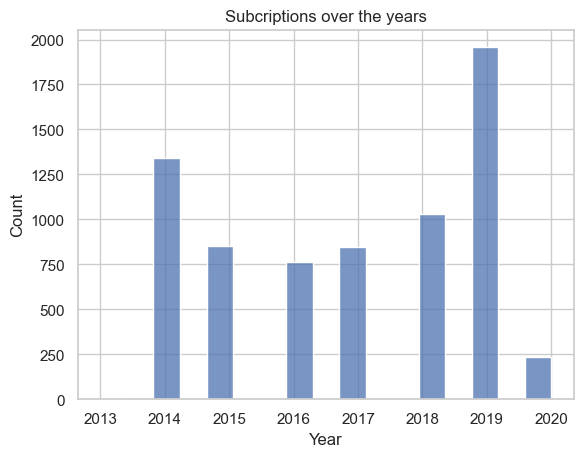

In [126]:
# We graph the subscriptions per year

sns.set(style="whitegrid")
sns.histplot(contract.begindate.dt.year, palette='Set2')
plt.title('Subcriptions over the years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [127]:
# 2013 months 

contract[contract['begindate'].dt.year == 2013]['begindate'].dt.month.value_counts()

begindate
10    3
12    3
11    2
Name: count, dtype: int64

In [128]:
# 2020 months

contract[contract['begindate'].dt.year == 2020]['begindate'].dt.month.value_counts()

begindate
1    233
Name: count, dtype: int64

**Observations**

- We have data from the year 2013 to the year 2020.
- We have created a graph showing the number of people acquiring plans per year. This allows us to see how much the acquisition of customers has increased or decreased over the years.
- The best year for the company in terms of the quantity of acquired customers has been the year 2019, with 1957 customers.
- We only have information from October to December of the year 2013.
- We only have information from the month of January of the year 2020.

#### `enddate`

In [129]:
# Creamos un nuevo dataset con la columna enddate y convertimos a datetime para poder hacer un análisis

end_date = contract[contract['enddate'] != 'No']
end_date.enddate = pd.to_datetime(end_date.enddate)
end_date.enddate.dt.year.value_counts()

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1911925666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_date.enddate = pd.to_datetime(end_date.enddate)


enddate
2019    1409
2020     460
Name: count, dtype: int64

In [130]:
# 2019 months

end_date[end_date['enddate'].dt.year == 2019]['enddate'].dt.month.unique()

array([12, 11, 10])

In [131]:
# 2020 months 

end_date[end_date['enddate'].dt.year == 2020]['enddate'].dt.month.unique()

array([1])

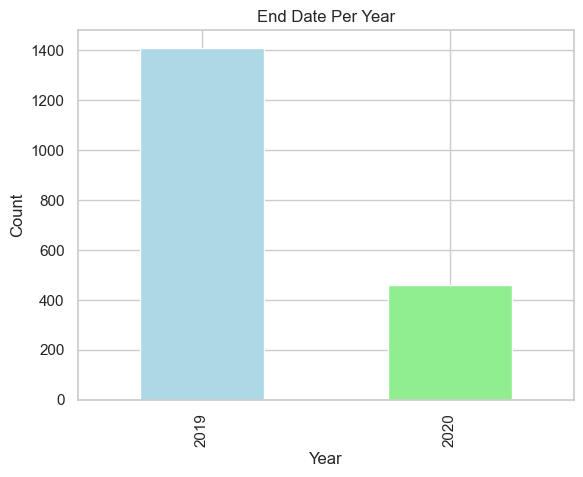

In [132]:
# We graph the amount of people that terminates their contract with us

end_date.enddate.dt.year.value_counts().plot(kind='bar',color=['lightblue','lightgreen'])
plt.title('End Date Per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

enddate
11    485
12    466
1     460
10    458
Name: count, dtype: int64


C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1892814328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_date['month'] = end_date.enddate.dt.month
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1892814328.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=end_date.month, palette='Set2')


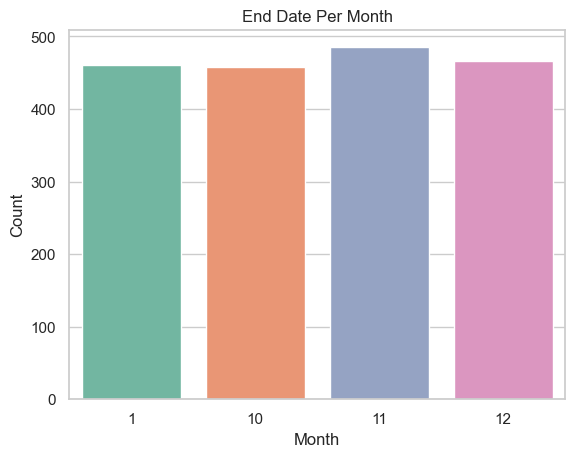

In [133]:
# We graph whe amoung of people that terminates their contract per month 

print(end_date.enddate.dt.month.value_counts())

end_date['month'] = end_date.enddate.dt.month
sns.countplot(x=end_date.month, palette='Set2')
plt.title('End Date Per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [134]:
# Cancelation info

(end_date.enddate - end_date.begindate).dt.days.describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
dtype: float64

In [135]:
# Amount of cancelations within less than a year. 

((end_date.enddate - end_date.begindate).dt.days < 365).sum()

999

In [136]:
# Churn rate

print('Churn Rate 2019')
print('{:.2%}'.format(len(end_date[end_date['enddate'].dt.year == 2019])/len(contract[contract['begindate'].dt.year == 2019])))

Churn Rate 2019
72.00%


In [137]:
print('Churn Rate 2020')
print('{:.2%}'.format(len(end_date[end_date['enddate'].dt.year == 2020])/len(contract[contract['begindate'].dt.year == 2020])))

Churn Rate 2020
197.42%


**Observations**

- We see that people have started canceling plans since October 2019.
- We observe that the months with the highest number of cancellations are the last three and the first month of the year. November and December are the months with the highest number of cancellations.
- The month of January of this year already surpasses October of last year in cancellations.
- We also see that we have people who have canceled after only 30 days of service and others who have been with us for up to 6 years. On average, people cancel after 1.5 years.
- We have nearly 100 people who have canceled within less than a year.
- We had a customer churn rate of 72% in 2019, and we are experiencing a much higher rate so far this year.

#### `type`

In [138]:
# We look for unique values 

contract.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [139]:
# We print the proportion for each value

contract.type.value_counts(normalize=True)

type
Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: proportion, dtype: float64

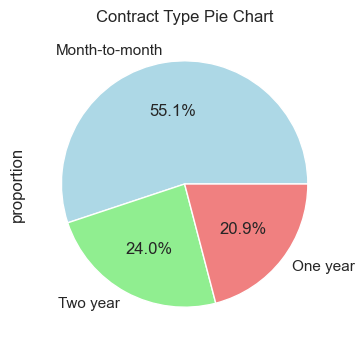

In [140]:
# We create a graph with the proportions 

plt.figure(figsize=(10,4))
contract.type.value_counts(normalize=True).plot(
    kind='pie',autopct='%1.1f%%',colors = ['lightblue', 'lightgreen', 'lightcoral']
)
plt.title('Contract Type Pie Chart')
plt.show()

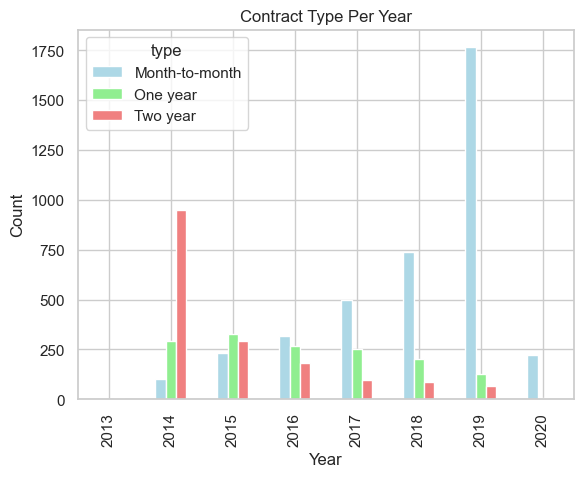

In [141]:
# We create a graph with the contract type preference per year 

contract['year'] = contract.begindate.dt.year
contract.pivot_table(values='enddate',index='year',columns='type',aggfunc='count').plot(
    kind='bar', color =['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Contract Type Per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

**Observations**

- We have three types of plans: annual, two-year, and monthly.
- 55% of our customers prefer monthly payment.
- We see that the number of monthly plans has increased over the years while one and two-year contracts have decreased. This makes it easier for people to cancel their plans.

#### `paperlessbilling`

In [142]:
# We look for unique values 

contract.paperlessbilling.unique()

array(['Yes', 'No'], dtype=object)

In [143]:
# We print the proportion for each value 

contract.paperlessbilling.value_counts(normalize=True)

paperlessbilling
Yes    0.592719
No     0.407281
Name: proportion, dtype: float64

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1449095708.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = contract.paperlessbilling, data=contract,palette='Set2')


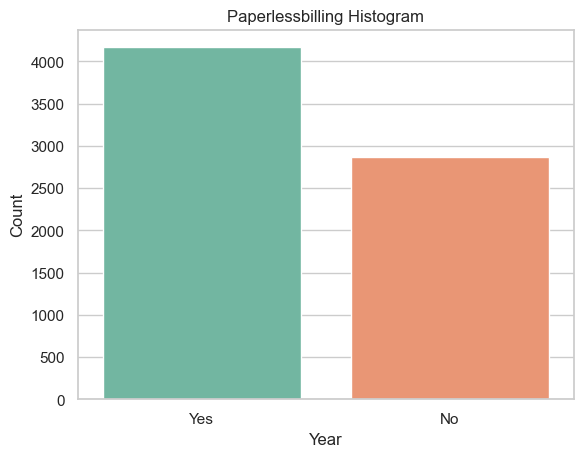

In [144]:
# We graph the proportions 

sns.countplot(x = contract.paperlessbilling, data=contract,palette='Set2')
plt.title('Paperlessbilling Histogram')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

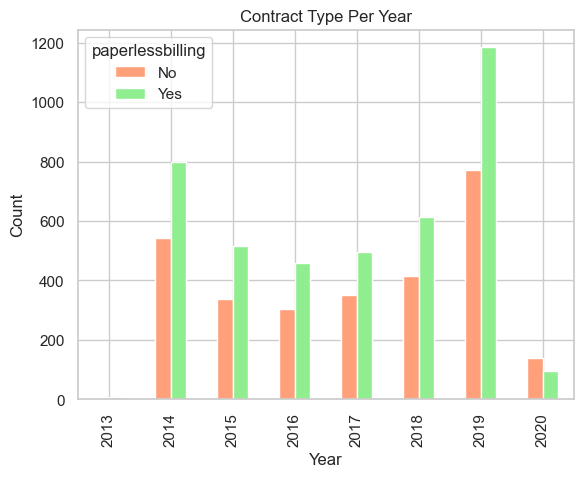

In [145]:
contract.pivot_table(values='enddate',index='year',columns='paperlessbilling',aggfunc='count').plot(
    kind='bar', color=['#FFA07A','lightgreen'])
plt.title('Contract Type Per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

**Observations**

- We have a column of binary values, YES and NO.
- We plotted the proportion of this variable and found that 59.27% of our customers prefer electronic billing.
- We also observe that the number of customers preferring electronic billing has been increasing, as well as those who do not prefer this type of billing.

`payment method`

In [146]:
# We look for unique values 

contract.paymentmethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [147]:
# We print the proportion for each value 

contract.paymentmethod.value_counts(normalize=True)

paymentmethod
Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: proportion, dtype: float64

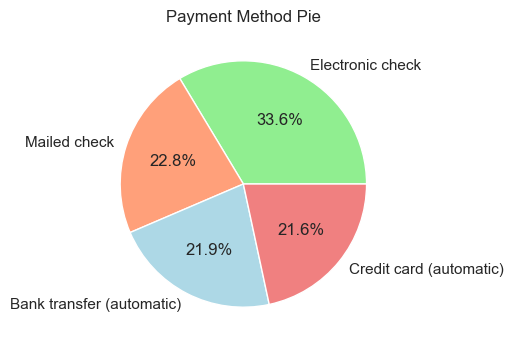

In [148]:
# We graph the proportions 

plt.figure(figsize=(10,4))
contract.paymentmethod.value_counts(normalize=True).plot(
    kind='pie',colors=['lightgreen','#FFA07A','lightblue','lightcoral'],autopct='%1.1f%%')
plt.title('Payment Method Pie')
plt.ylabel('')
plt.show()

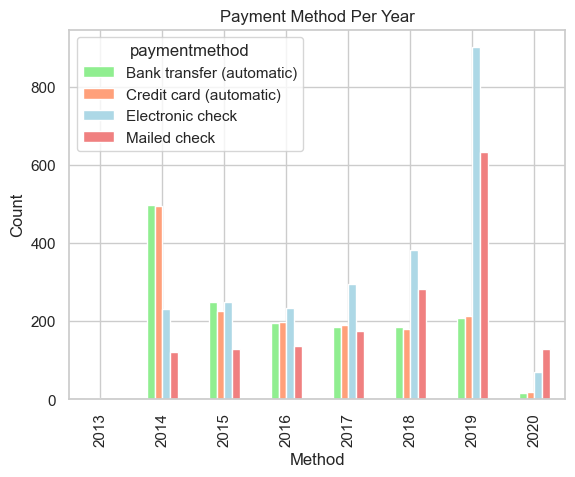

In [149]:
contract.pivot_table(values='enddate',index='year',columns='paymentmethod',aggfunc='count').plot(
    kind='bar',color=['lightgreen','#FFA07A','lightblue','lightcoral'])
plt.title('Payment Method Per Year')
plt.xlabel('Method')
plt.ylabel('Count')
plt.show()

**Observations**

- We have four different payment methods: Bank transfer, credit card, electronic check, and check via email. The first two mentioned methods are automatic methods.
- 33.6% of users prefer to pay via electronic check.
- We observe that over the years, contracts with automatic payment methods have been decreasing while contracts with non-automatic payments have been increasing.


`monthlycharges`

In [150]:
# We create function to analize outliers 

def outliers(df,col,ylabel=None):
    df.boxplot(col,figsize=(8,5))
    plt.title('Boxplot of ' + col)
    plt.ylabel(ylabel)
    plt.show()

    min = df[col].min()
    values_0 = len(df[df[col] <= 0])
    percentage_values_0 = '{:.2%}'.format(len(df[df[col] <= 0])/len(df))

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    up_limit = Q3 + IQR
    low_limit = Q1 - IQR

    values_up_limit = len(df[df[col] >= up_limit])
    values_low_limit = len(df[df[col] <= low_limit])

    percentage_up_limit = '{:.2%}'.format(len(df[df[col] >= up_limit])/len(df))
    percentage_low_limit = '{:.2%}'.format(len(df[df[col] <= low_limit])/len(df))

    print(df[col].describe())
    print()
    print(f'IQR of {col} is {IQR}')
    print()
    
    print(f'The lower-limit is {low_limit}')
    print()
    print(f'The amount of values equal to or less than {low_limit} is {values_low_limit}')
    print()
    print(f'The percentage of values equal to or less than {low_limit} is {percentage_low_limit}')

    print()
    print(f'The upper-limit is {up_limit}')
    print()
    print(f'The amount of values equal to or greater than {up_limit} is {values_up_limit}')
    print()
    print(f'The percentage of values equal to or greater than {up_limit} is {percentage_up_limit}')

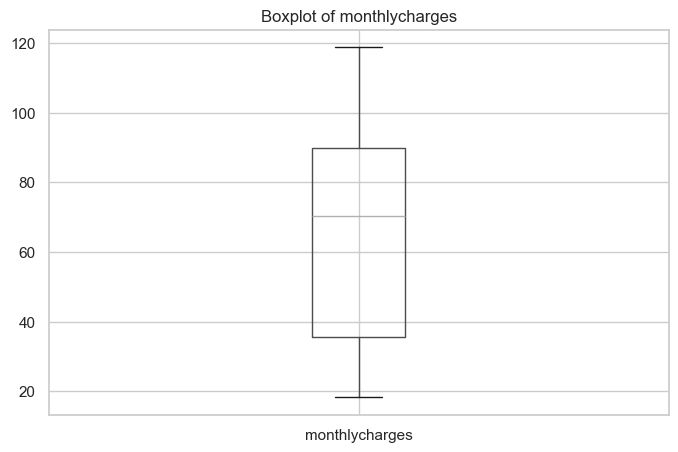

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthlycharges, dtype: float64

El IQR de monthlycharges es 54.275

EL limite inferior de nuestro boxplot es -18.6875

La cantidad de valores iguales o menores a -18.6875 es 0

El porcentaje de valores iguales o menores a -18.6875 es 0.00%

EL limite superior es de nuestro boxplot es 144.1375

La cantidad de volores iguales o superiores a 144.1375 es 0

Elporcentaje de valores iguales o superiores a 144.1375 es 0.00%


In [151]:
# We look for outliers 

outliers(contract,'monthlycharges')

<Axes: xlabel='monthlycharges', ylabel='Count'>

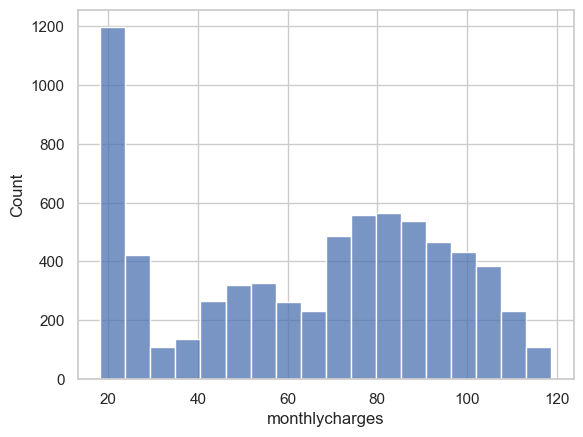

In [152]:
# We create a histplot

sns.histplot(contract.monthlycharges)

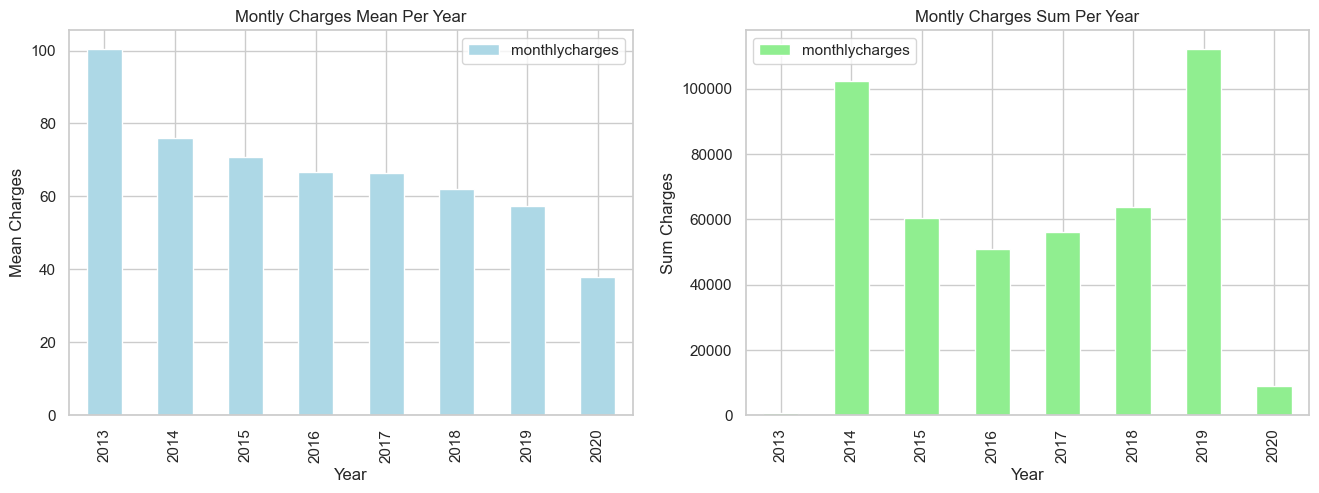

In [153]:
# We create a graph with the monthly charges mean per year 

fig, axs = plt.subplots(1,2, figsize=(16,5))
contract.pivot_table(values='monthlycharges',index='year',aggfunc='mean').plot(kind='bar',ax=axs[0], color='lightblue')
axs[0].set_title('Montly Charges Mean Per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Mean Charges')

# We create a graph with the monthly charges sum per year 

contract.pivot_table(values='monthlycharges',index='year',aggfunc='sum').plot(kind='bar',ax=axs[1],color='lightgreen')
plt.title('Montly Charges Sum Per Year')
plt.xlabel('Year')
plt.ylabel('Sum Charges')
plt.show()


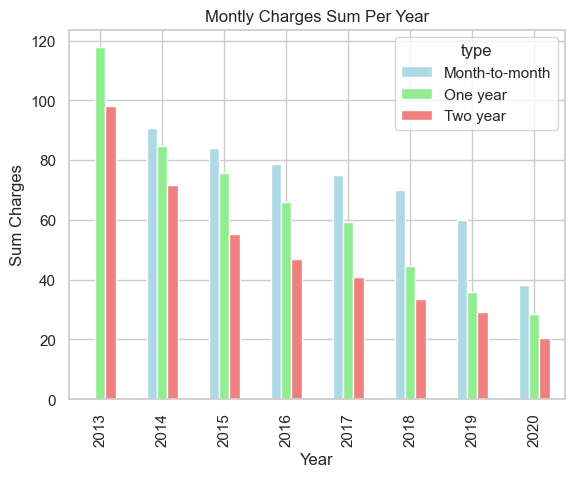

In [154]:
# We create a chart to visualize the average price of each type of plan per year.

contract.pivot_table(values='monthlycharges',index='year',columns='type',aggfunc='mean').plot(
    kind='bar',color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Montly Charges Sum Per Year')
plt.xlabel('Year')
plt.ylabel('Sum Charges')
plt.show()

**Observations**

- On average, people pay $64 per plan.
- Monthly payments range from $18.25 to $118.75.
- We do not have values considered outliers in this column.
- We can see in our charts that the average price of plans has decreased. This may be because people have plans with fewer benefits or simply because the price has decreased.
- Despite the decrease in plan prices over the years, profits have increased since 2016.
- We also observe that the price has decreased for all different types of plans.


`totalcharges`

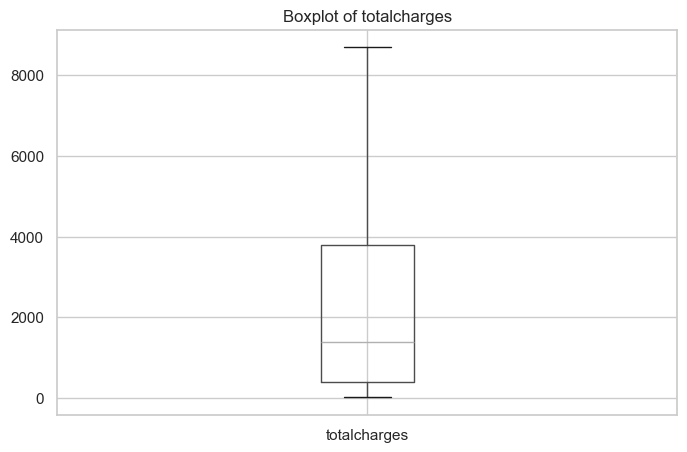

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: totalcharges, dtype: float64

El IQR de totalcharges es 3393.2875000000004

EL limite inferior de nuestro boxplot es -2991.8375000000005

La cantidad de valores iguales o menores a -2991.8375000000005 es 0

El porcentaje de valores iguales o menores a -2991.8375000000005 es 0.00%

EL limite superior es de nuestro boxplot es 7188.025000000001

La cantidad de volores iguales o superiores a 7188.025000000001 es 272

Elporcentaje de valores iguales o superiores a 7188.025000000001 es 3.87%


In [155]:
# We look for outliers 

outliers(contract,'totalcharges')

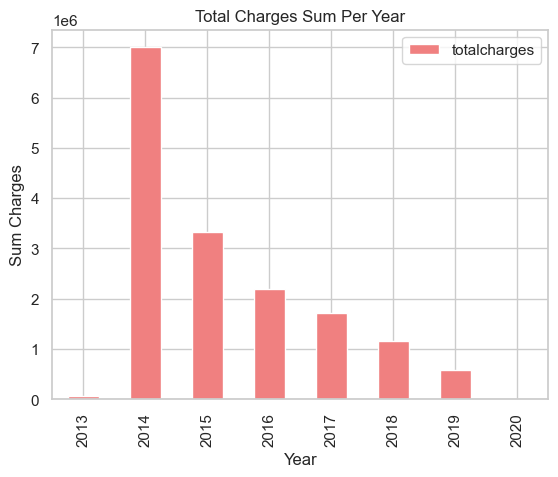

In [156]:
# We create a chart for total charges sum per year

contract.pivot_table(values='totalcharges',index='year',aggfunc='sum').plot(kind='bar',color='lightcoral')
plt.title('Total Charges Sum Per Year')
plt.xlabel('Year')
plt.ylabel('Sum Charges')
plt.show()

**Observations**

- On average, annual payments per customer are $2283.30.
- We practically have no outliers in this column. We only have 3.87% of values greater than our upper limit.
- We observe that over the years, the total sum of payments collected from customers per year has decreased. This may be due to the cancellation of contracts in such a short time. We have seen that we have customers who have been with us for less than a year. This decreases the value of this column.

### Personal

In [157]:
# We print the first rows of our dataset

personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [158]:
# We print general info to look for missing data

personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [159]:
# We print a describe

personal.describe(include='all')

,customerid,gender,seniorcitizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


**Initial Observations**

- We have a dataset with 7043 observations and 5 columns.
- Apparently, we do not have any missing values.
- The data types of each column appear to be correct.
- Most of the columns contain binary information.

In [160]:
# We print the unique values of this column

personal.seniorcitizen.unique()

array([0, 1], dtype=int64)

With this, we verify that the `seniorcitizen` column also has binary values. This will make our analysis of these columns easier

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1012569023.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=personal[column_name],data=personal, ax=ax,palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1012569023.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=personal[column_name],data=personal, ax=ax,palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1012569023.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=personal[column_name],data=personal, ax=ax,palette='Set2')
C

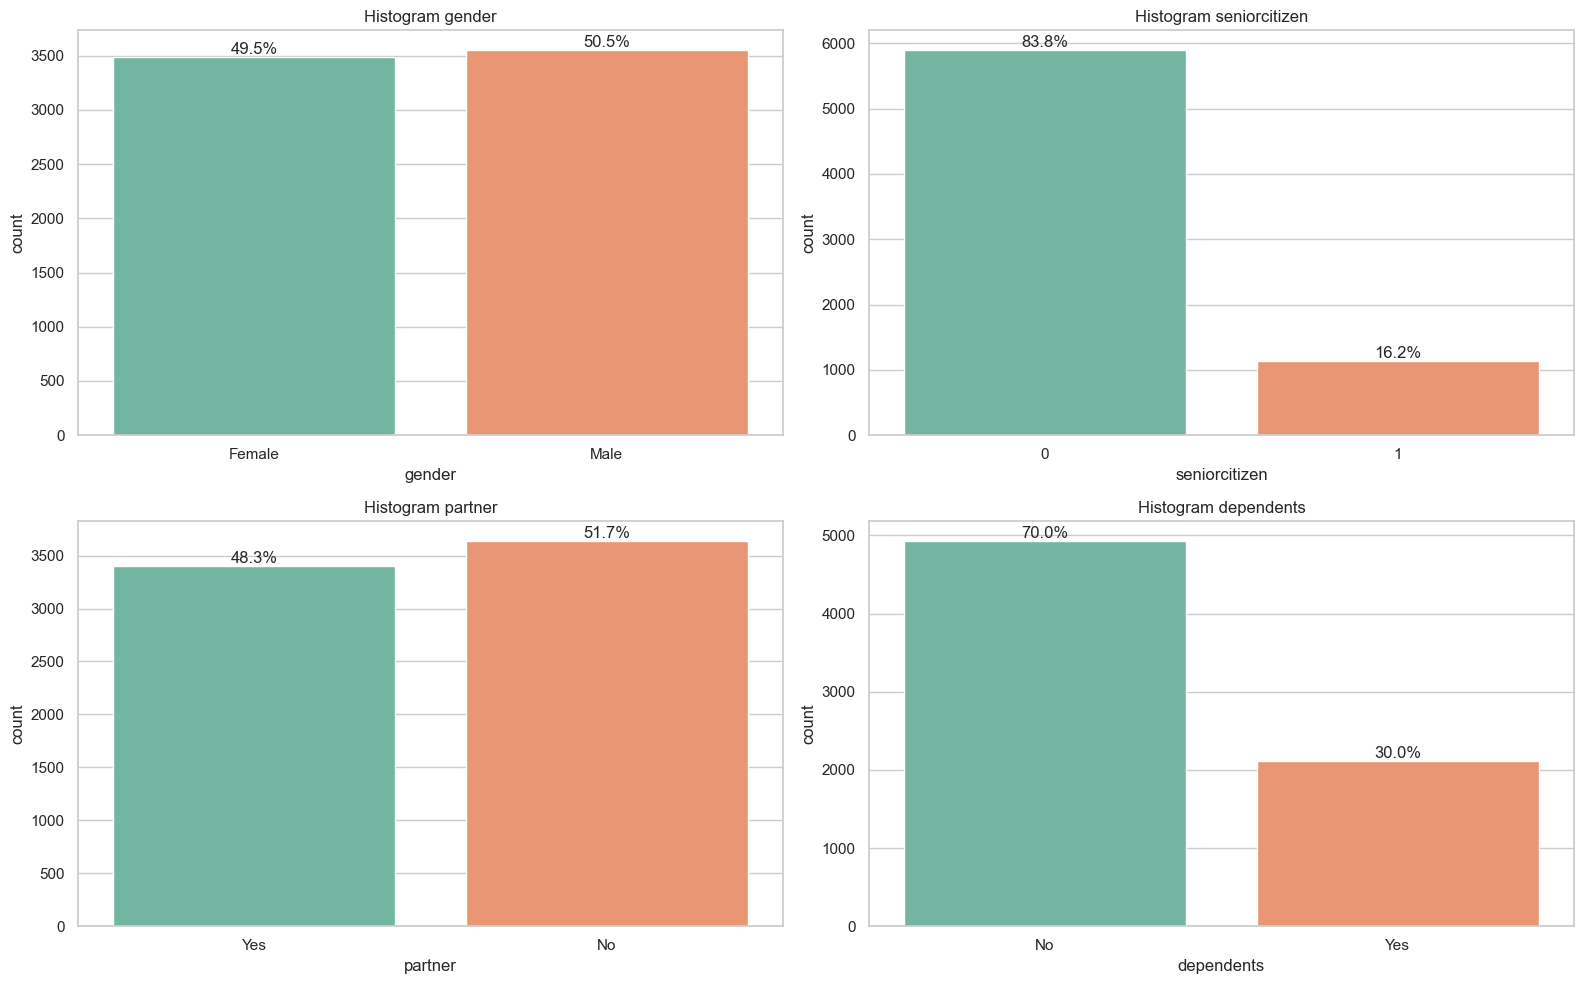

In [161]:
# We create a chart for each column

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        subplot_index = i * 2 + j
        if subplot_index < len(personal.columns) - 1:
            column_index, column_name = subplot_index, personal.drop(columns='customerid').columns[subplot_index]
            sns.countplot(x=personal[column_name],data=personal, ax=ax,palette='Set2')
            ax.set_title(f'Histogram {column_name}')
            
            total_count = len(personal)
            counts = personal[column_name].value_counts()
            for patch in ax.patches:
                height = patch.get_height()
                percentage = height / total_count * 100
                ax.annotate(f'{percentage:.1f}%', (patch.get_x() + patch.get_width() / 2, height),
                            ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Observations**

- We have a dataset with 7043 observations and 5 columns.
- All columns have binary values except for `customerid`.
- We have created histograms for each column to understand the proportion of each element.
- In our `gender` column, we see that 50.5% of our customers are male.
- In our `seniorcitizen` column, we see that 83.8% of our customers are not senior citizens.
- In our `partner` column, we see that 51.7% of our customers are not married.
- In our `dependets` column, we see that 70% of our customers do not have children or dependents.


### Internet

In [162]:
# We print the first rows

internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [163]:
# We print the general info

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [164]:
# We print a describe

internet.describe(include='all')

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\678527800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=internet[column_name], ax=ax, palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\678527800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=internet[column_name], ax=ax, palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\678527800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=internet[column_name], ax=ax, palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipy

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\678527800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=internet[column_name], ax=ax, palette='Set2')
C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\678527800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=internet[column_name], ax=ax, palette='Set2')


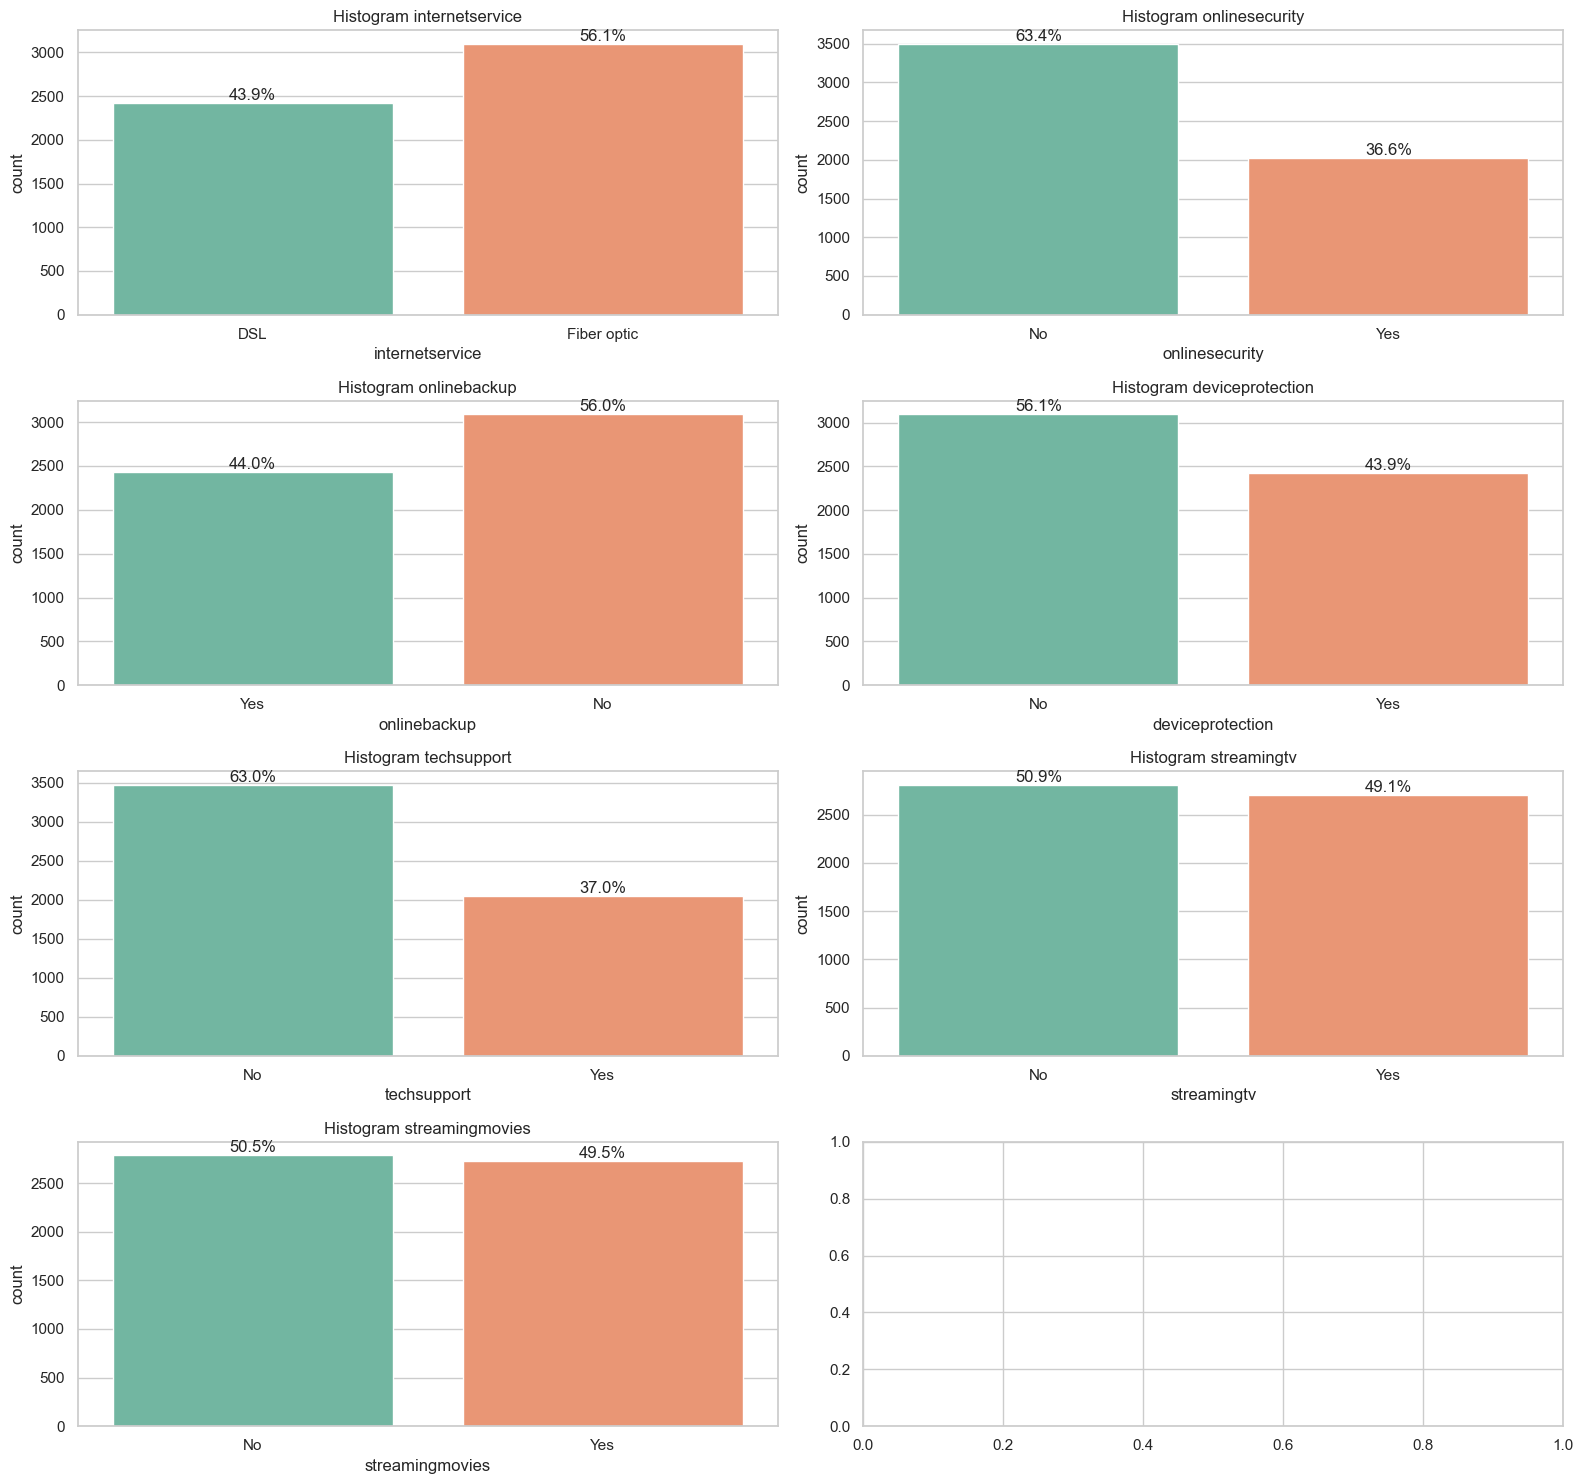

In [165]:
# We create a chart for each column

fig, axs = plt.subplots(4, 2, figsize=(16, 15))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        subplot_index = i * 2 + j
        if subplot_index < len(internet.columns) - 1:
            column_index, column_name = subplot_index, internet.drop(columns='customerid').columns[subplot_index]
            sns.countplot(x=internet[column_name], ax=ax, palette='Set2')
            ax.set_title(f'Histogram {column_name}')
            
            total_count = len(internet)
            counts = internet[column_name].value_counts()
            for patch in ax.patches:
                height = patch.get_height()
                percentage = height / total_count * 100
                ax.annotate(f'{percentage:.1f}%', (patch.get_x() + patch.get_width() / 2, height),
                            ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Observations**

- We have a dataset with 5517 samples and 8 columns. We have fewer samples than in our previous datasets.
- All our columns, except the `customerid` column, are binary.
- We have created graphs for each variable to understand their distribution a little better.
- In our `internetservice` column, we see that 56.1% of our customers prefer fiber optic.
- In our `onlinesecurity` column, we see that 63.4% of our customers do not have this service.
- In our `onlinebackup` column, we see that 56.0% of our customers do not have this service.
- In our `deviceprotection` column, we see that 56.1% of our customers do not have this service.
- In our `techsupport` column, we see that 63.0% of our customers do not have this service.
- In our `streamingtv` column, we see that 50.9% of our customers do not have this service.
- In our `streamingmovies` column, we see that 50.5% of our customers do not have this service.

### Phone

In [166]:
# We print the first rows

phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [167]:
# We print the general info

phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [168]:
# We print a describe

phone.describe(include='all')

,customerid,multiplelines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [169]:
# We print the distribution of our multiplelines variable 

phone.multiplelines.value_counts(normalize=True)

multiplelines
No     0.532935
Yes    0.467065
Name: proportion, dtype: float64

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\4238956797.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=phone['multiplelines'],palette='Set2')


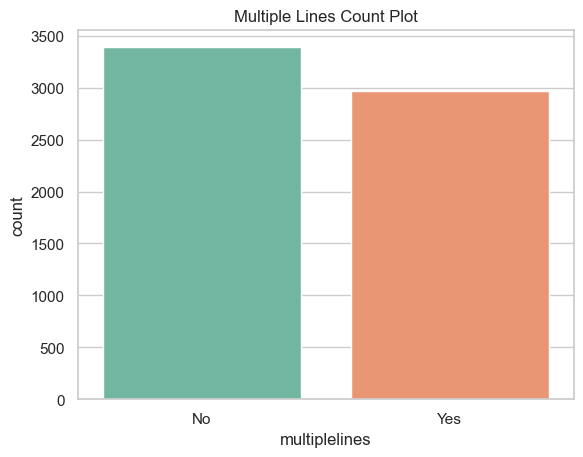

In [170]:
# We create a chart to visualize the distribution 
sns.countplot(x=phone['multiplelines'],palette='Set2')
plt.title('Multiple Lines Count Plot')
plt.show()

**Observations**

- We have a dataset with 6361 observations and 2 columns.
- The multiplelines column is binary.
- We have analyzed its proportion and created a graph to visualize it. 53.29% of our customers do not have multiple lines.
- We see that this dataset has fewer observations than the first two. This may be because not all customers have a phone line in their plan.


### Observations EDA

We have analyzed each dataset separately to better understand all the data we have in order to better prepare ourselves for our task of creating machine learning models. Some of the important findings for the task are:

- We have four datasets with information relevant to the same customers.
- Not all datasets have the same number of samples.
- Our target variable has contract end dates. Our goal is to detect whether a customer will cancel or not. We do not need these dates.
- We have several binary categorical variables (Yes/No).
- Our target variable is unbalanced.

**Next Steps**

- We need to merge our datasets into one.
- We could conduct a new exploratory analysis with the new dataset.
- We will need to clean the new dataset to remove duplicate data or missing values.
- We will need to prepare our dataset for model training. Since we have some categorical variables, we will need to decide what to do with these columns. We could use the one-hot-encoder algorithm to transform the data.
- Since our target variable is unbalanced, we also need to decide how to balance our dataset before training. The method considered for this could be oversampling.
- We will train 6 different models and find the one with the best results.
- We will create a report with our findings.

### Datasets Merge

In [171]:
# We merge all our datasets in one

final_df = contract.merge(personal,how='inner').merge(internet,how='left').merge(phone,how='left')

# We print the first rows of our new dataset

final_df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [172]:
# We print general info of our dataset

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   year              7032 non-null   int32         
 9   gender            7032 non-null   object        
 10  seniorcitizen     7032 non-null   int64         
 11  partner           7032 non-null   object        
 12  dependents        7032 non-null   object        
 13  internetservice   5512 non-null   object        
 14  onlinesecurity    5512 n

In [173]:
# We look for duplicates in our dataset

final_df.customerid.duplicated().sum()

0

In [174]:
# We verify we have all of our original samples

len(set(final_df.customerid) - set(contract.customerid))

0

**Observations**

- By merging all datasets, we obtained a dataset with 7032 samples and 21 variables or columns.
- We have searched for duplicates of the samples and have not found any.
- Merging all datasets has generated columns with missing values. This is because people do not consume all the services offered. We will replace all null values so that they do not affect us in model creation.
- We change all date data in the `enddate` column to 'Yes'.


In [175]:
# We fill in the missing values in their the respective columns

fillna_columns = list(internet.drop(columns=['customerid','internetservice']).columns)

final_df[['multiplelines','internetservice']] = final_df[['multiplelines','internetservice']].fillna('NA')

final_df[fillna_columns] = final_df[fillna_columns].fillna('No')

In [176]:
# We change all data data in the endate column to Yes

final_df.enddate = final_df.enddate.apply(lambda x: 'Yes' if x != 'No' else 'No')

In [177]:
# We check for missing values 

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   year              7032 non-null   int32         
 9   gender            7032 non-null   object        
 10  seniorcitizen     7032 non-null   int64         
 11  partner           7032 non-null   object        
 12  dependents        7032 non-null   object        
 13  internetservice   7032 non-null   object        
 14  onlinesecurity    7032 n

In [178]:
# We verify the changes 

final_df.enddate.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: enddate, dtype: object

#### EDA final_df

In [179]:
# We print some rows

final_df_copy = final_df.copy()
final_df_copy.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NA
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,2019,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NA
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,2019,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [180]:
# We create a new columns with the amount of services per client

service_columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
                   'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

final_df_copy['totalservices'] = final_df_copy[service_columns].apply(lambda row: sum(row == 'Yes'), axis=1)

In [181]:
# We analize the distribution of totalservices

final_df_copy.totalservices.value_counts(normalize=True)

totalservices
0    0.236490
1    0.164391
3    0.139078
2    0.136092
4    0.132395
5    0.102247
6    0.059727
7    0.029579
Name: proportion, dtype: float64

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\1979701363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df_copy.totalservices,palette='Set2')


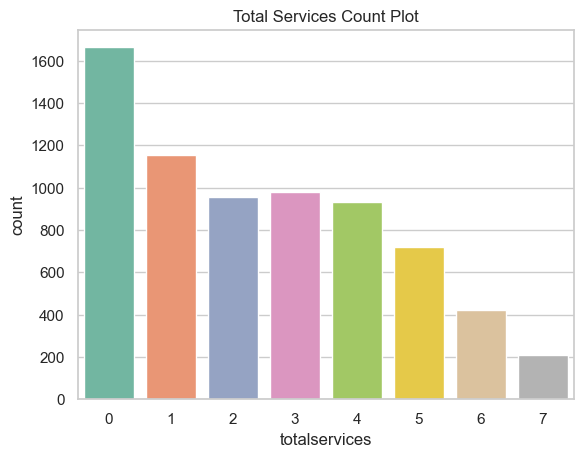

In [182]:
# We create a chart to visualize the distribution

sns.countplot(x=final_df_copy.totalservices,palette='Set2')
plt.title('Total Services Count Plot')
plt.show()

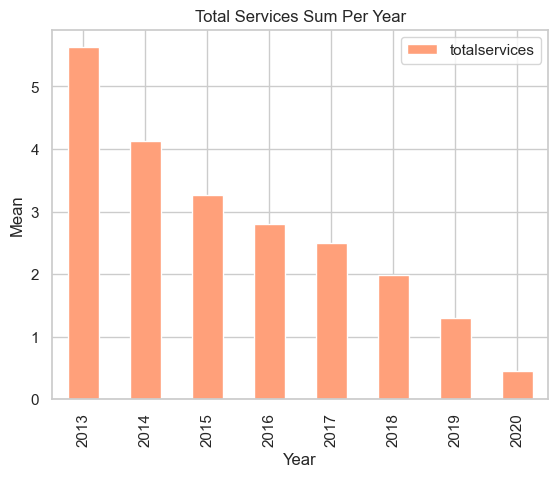

In [183]:
# We create a chart to analize the mean totalservices pero year

final_df_copy.pivot_table(values='totalservices',index='year',aggfunc='mean').plot(kind='bar',color='#FFA07A')
plt.title('Total Services Sum Per Year')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.show()

C:\Users\ZonaDigital\AppData\Local\Temp\ipykernel_9744\2080294815.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df_copy[final_df_copy['enddate'] == 'Yes'].totalservices,palette='Set2')


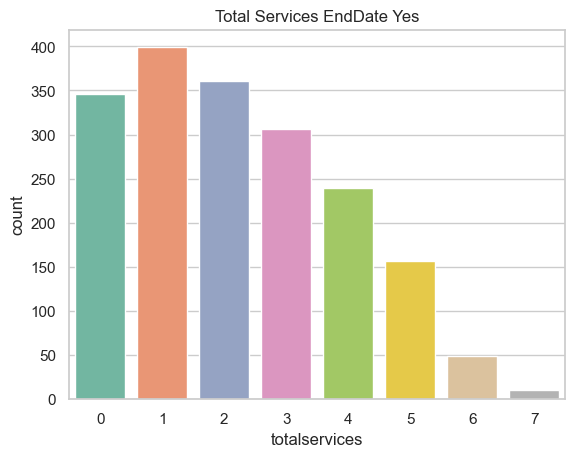

In [184]:
# We create a chart to visualize the distribution of people that has terminated their services with us. 

sns.countplot(x=final_df_copy[final_df_copy['enddate'] == 'Yes'].totalservices,palette='Set2')
plt.title('Total Services EndDate Yes')
plt.show()

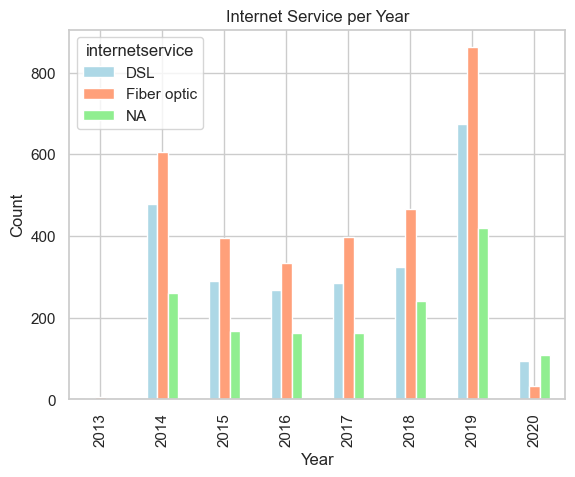

In [185]:
# We create a chart to analize the type of internet service per year

final_df.pivot_table(
    index='year',columns=['internetservice'],values='monthlycharges',aggfunc='count').plot(
    kind='bar',color=['lightblue','#FFA07A','lightgreen'])
plt.title('Internet Service per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

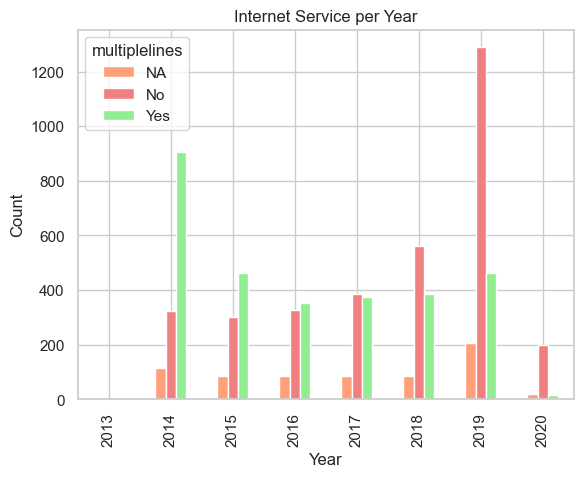

In [186]:
# We create a chart to analize the amount of lines per client per year

final_df.pivot_table(
    index='year',columns='multiplelines',values='monthlycharges',aggfunc='count').plot(
    kind='bar',color=['#FFA07A','lightcoral','lightgreen'])
plt.title('Internet Service per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [187]:
# We create a correlation matrix 

final_df_copy.corr(numeric_only=True)

,monthlycharges,totalcharges,year,seniorcitizen,totalservices
monthlycharges,1.000000,0.651065,-0.263086,0.219874,0.773098
totalcharges,0.651065,1.000000,-0.819304,0.102411,0.787082
year,-0.263086,-0.819304,1.000000,-0.027386,-0.525341
seniorcitizen,0.219874,0.102411,-0.027386,1.000000,0.095516
totalservices,0.773098,0.787082,-0.525341,0.095516,1.000000


<Axes: >

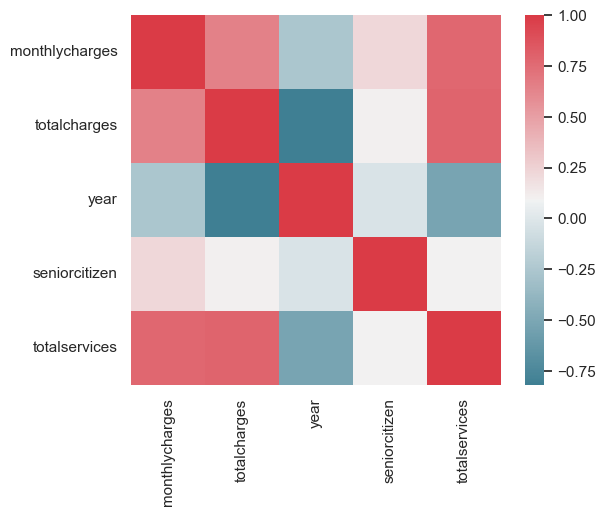

In [188]:
# We graph the correlation 

corr = final_df_copy.corr(numeric_only=True)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

**Observations EDA full_df**

- In this section, we created a new column indicating the number of services each person had in their contract.
- We discovered that the majority of our customers, in this case 23.64% of them, only have one phone line. The percentage decreases as the number of services increases.
- We created a graph to show the average number of services per year. We found that on average, the number of services contracted per customer has decreased since 2014.
- We also created a graph to analyze the number of services contracted by people who ended their contracts. The people who terminated their contracts had between 0 and 7 services. (0 means they only had one phone line)
- We created a graph to analyze how each type of internet service has increased or decreased per year. We found that each service has increased proportionally to the increase in the number of users, with fiber optic internet being the most contracted. We also see that the number of people not contracting internet service has been increasing.
- We created a graph to analyze phone lines per customer per year. We found that the number of people who only have one phone line has been increasing over the years.
- We created a correlation graph. We found that the monthlycharges and totalcharges variables are positively correlated. - - We also see that totalservices is also positively correlated with each of these aforementioned variables.



**Next Steps**

- In our exploratory analysis, we observed that our target variable was imbalanced. This could affect the performance of our models. We could use various methods to balance our dataset. For this project, we will use the oversampling method.
- We have already noticed that we have several categorical columns that need to be encoded for some of our models. We will use the OHE algorithm to encode all our categorical variables and train our models accordingly. 

**Models**

- Dummy
- Logistic Regression
- Decision Tree
- Random Forest
- LightGBM
- CatBoost
- Neural Networks

## Data preparation for model creation

In [189]:
# We eliminate the year column

final_df = final_df.drop(columns='year',axis=1)

In [194]:
# We use the OHE method to codify our columns

ohe_columns = final_df.drop(columns=['customerid','begindate','seniorcitizen','monthlycharges','totalcharges']).columns
final_df_ohe = pd.get_dummies(final_df,columns=ohe_columns,drop_first=True,dtype=int)
final_df_ohe.head()

,customerid,begindate,monthlycharges,totalcharges,seniorcitizen,enddate_Yes,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),...,internetservice_Fiber optic,internetservice_NA,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,multiplelines_No,multiplelines_Yes
0,7590-VHVEG,2020-01-01,29.85,29.85,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,5575-GNVDE,2017-04-01,56.95,1889.50,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,3668-QPYBK,2019-10-01,53.85,108.15,0,1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
3,7795-CFOCW,2016-05-01,42.30,1840.75,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,0,0
4,9237-HQITU,2019-09-01,70.70,151.65,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


In [196]:
# We create a seed
random_state = 12345

# We split our dataset into target and features 

features_ohe = final_df_ohe.drop(columns=['enddate_Yes','customerid','begindate'])
target_ohe = final_df_ohe.enddate_Yes


In [197]:
# We split our datasets into train and test

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2,random_state=random_state)

In [198]:
# We create a function that will help us graph our results 

def get_roc_plot_data(y, predictions):
    fpr, tpr, _ = roc_curve(y,
                            predictions,
                            pos_label=None,
                            drop_intermediate=True)
    auc = round(roc_auc_score(y, predictions), 5)

    return fpr, tpr, auc


def plot_roc(custom_axis, y, predictions):

    multiple_curves = isinstance(y, dict)

    custom_axis.axis([-0.01,1.01,0,1.01])
    custom_axis.set(xlabel="False Positive Rate", ylabel="Recall")
    custom_axis.set_title("ROC Curve")

    if not multiple_curves:
        fpr, tpr, auc = get_roc_plot_data(y, predictions)

        custom_axis.plot(fpr, tpr)
        custom_axis.text(0.65, 0.02, 'AUC: ' + str(auc), fontsize=12)
    else:
        for i in range(len(y)):
            model = list(y.keys())[i]
            fpr, tpr, auc = get_roc_plot_data(y[model], predictions[model])

            custom_axis.plot(fpr, tpr, label=model)
            custom_axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            custom_axis.text(0.50, 0.02 + i*0.1, f"{model} AUC: {str(auc)}", fontsize=12)

    custom_axis.plot([0,1],[0,1])

    return []

## Models
### Dummy

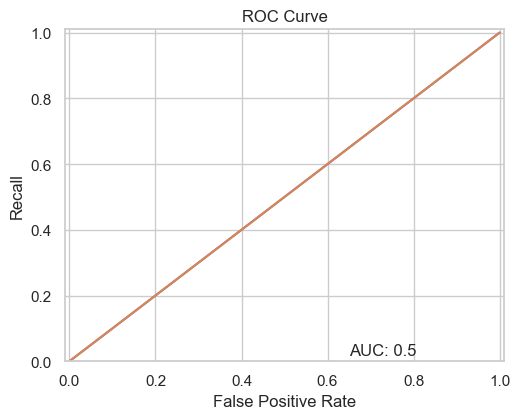

In [199]:
# We create a Dummy model

model = DummyClassifier(strategy='most_frequent')
model.fit(features_train_ohe, target_train_ohe)
dummy_pred = model.predict(features_test_ohe)
fig, ax = plt.subplots(figsize=(6, 5))

# We use the function to graph our output

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= dummy_pred
)

fig.tight_layout(pad=3.0)
plt.show()

### DecissionTree

In [200]:
# We use GirSearch to try out different hyperparameters and fins the best model 

param_grid = {
    'max_depth':[None,2,5,10],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state = random_state),
        param_grid=param_grid, 
        cv=5,
        scoring='roc_auc')

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_tree = best_model.predict(features_test_ohe)

print(best_model)
print(best_params)
print(best_score)

DecisionTreeClassifier(max_depth=5, random_state=12345)
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.8233904140482954


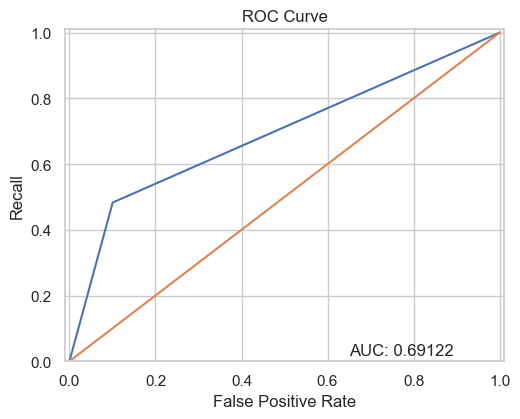

In [201]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= predict_tree
)

fig.tight_layout(pad=3.0)
plt.show()

### RadomForest

In [202]:
# We use GirSearch to try out different hyperparameters and fins the best model 

param_grid = {
    'n_estimators':[50,100,150],
    'max_depth':[None,3,5,7,9,11],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state = random_state), 
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_forest = best_model.predict(features_test_ohe)

print(best_model)
print(best_params)
print(best_score)

RandomForestClassifier(max_depth=7, n_estimators=150, random_state=12345)
{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 150}
0.845386428955744


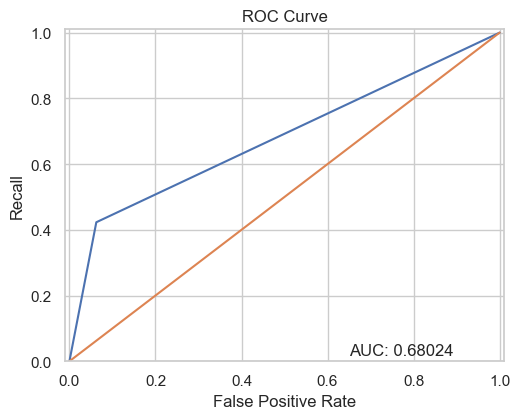

In [203]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= predict_forest
)

fig.tight_layout(pad=3.0)
plt.show()

### LogisticRegression ClassWeight

In [204]:
# We use GirSearch to try out different hyperparameters and fins the best model 

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(
        class_weight = 'balanced', max_iter = 5000, solver = 'liblinear'), 
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_lr = best_model.predict(features_test_ohe)

print(best_model)
print(best_params)
print(best_score)

LogisticRegression(C=10, class_weight='balanced', max_iter=5000, penalty='l1',
                   solver='liblinear')
{'C': 10, 'penalty': 'l1'}
0.8364449188191841


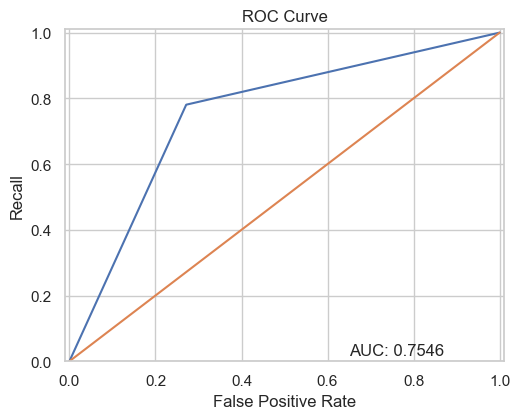

In [205]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= predict_lr
)

fig.tight_layout(pad=3.0)
plt.show()

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1486, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264178 -> initscore=-1.024366
[LightGBM] [Info] Start training from score -1.024366


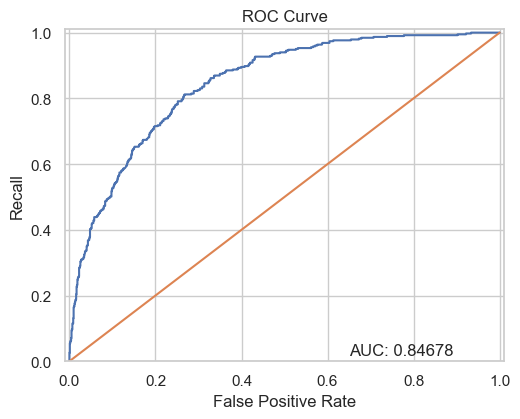

In [206]:
# We create a lightgmb model

train_data = lgb.Dataset(features_train_ohe,label=target_train_ohe)
test_data = lgb.Dataset(features_test_ohe,label=target_test_ohe)
params = {
    'objective': 'binary',  
    'metric': 'binary_logloss', 
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
num_round = 100
bts = lgb.train(params, train_data, num_round, valid_sets=[test_data])
lgb_predict = bts.predict(features_test_ohe,num_iteration=bts.best_iteration)

# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= lgb_predict
)

fig.tight_layout(pad=3.0)
plt.show()

### CatBoost

In [207]:
# We use GirSearch to try out different hyperparameters and fins the best model 

param_grid = {
     'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0),
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_cb = best_model.predict(features_test_ohe)

print(best_model)
print(best_params)
print(best_score)

{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 50}
0.848150677321702


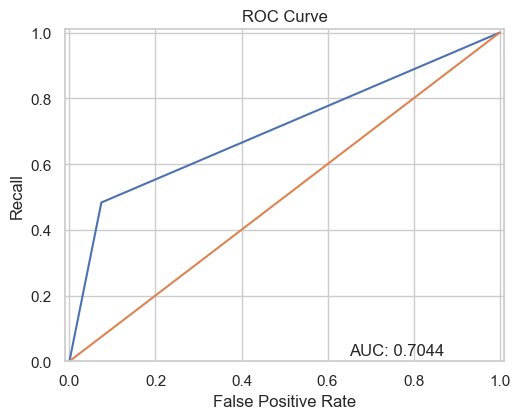

In [208]:
# We graph out output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= predict_cb
)

fig.tight_layout(pad=3.0)
plt.show()

### Neural Networks

Train on 5625 samples, validate on 1407 samples
Epoch 1/5
5568/5625 [============================>.] - ETA: 0s - loss: 82.9298 - acc: 0.5623

c:\Users\ZonaDigital\Documents\3. Repositorios\Triple-Ten\Sprint_17_Final_Project\venv\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5625/5625 [==============================] - 1s 166us/sample - loss: 82.0996 - acc: 0.5652 - val_loss: 1.3977 - val_acc: 0.7136
Epoch 2/5
5625/5625 [==============================] - 0s 83us/sample - loss: 0.7525 - acc: 0.7499 - val_loss: 0.5338 - val_acc: 0.7818
Epoch 3/5
5625/5625 [==============================] - 0s 83us/sample - loss: 0.5952 - acc: 0.7687 - val_loss: 0.4531 - val_acc: 0.7868
Epoch 4/5
5625/5625 [==============================] - 0s 82us/sample - loss: 0.9173 - acc: 0.7492 - val_loss: 0.7861 - val_acc: 0.7733
Epoch 5/5
5625/5625 [==============================] - 1s 104us/sample - loss: 0.6182 - acc: 0.7689 - val_loss: 0.5765 - val_acc: 0.7775


c:\Users\ZonaDigital\Documents\3. Repositorios\Triple-Ten\Sprint_17_Final_Project\venv\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


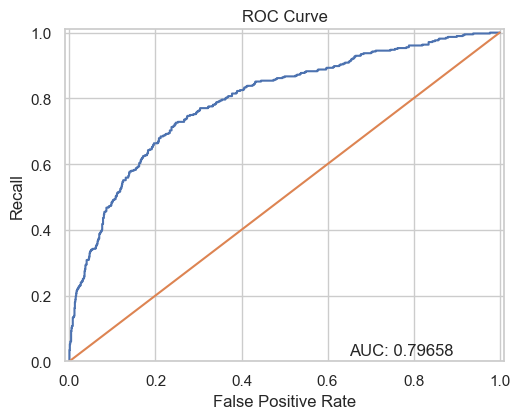

In [226]:
# We create a simple neural network model

model = Sequential()
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    features_train_ohe.values, target_train_ohe.values, epochs=5, batch_size=32, validation_data=(features_test_ohe.values, target_test_ohe.values))
neu_net_predict = model.predict(features_test_ohe.values)

# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_ohe,
    predictions= neu_net_predict
)

fig.tight_layout(pad=3.0)
plt.show()

**Conclutions First Models**

**Dummy**
- Roc_Auc 0.5


**DecisionTree**
- Best Params: max_depth 5, min_samples_leaf 1, min_samples_split 2 
- Roc_Auc training: 0.823
- Roc_Auc test: 0.691

**RandomForest**
- Best Params: max_depth 7, min_samples_leaf 2, n_estimators 150 
- Roc_Auc training: 0.845
- Roc_Auc test: 0.68

**LogisticRegression**
- Best Params: C 0.1, class_weight “Balanced”, max_iter 5000, penalty L2
- Roc_Auc training: 0.836
- Roc_Auc test: 0.759

**LightGBM**
- Params: 'objective': 'binary', 'metric': 'binary_logloss',  'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9
- Roc_Auc test: 0.846

**CatBoost**
- Best Params: depth 4, learning_rate 0.1, n_estimators 50
- Roc_Auc training: 0.848
- Roc_Auc test: 0.704

**Neural Network**
- Roc_Auc test: 0.744

The best model was the LightGBM model with a 0.846 roc_auc on the test set.

## Upsumple Models

In [212]:
# We create a function to upsample our data

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

# We use the function on our data

features_upsample_ohe, target_upsample_ohe = upsample(
    features_train_ohe, target_train_ohe, 10
)

In [213]:
# We split our data into train and test

features_train_oheu, features_test_oheu, target_train_oheu, target_test_oheu = train_test_split(
    features_upsample_ohe, target_upsample_ohe, test_size = 0.2, random_state=random_state)

#### Dummy Upsample

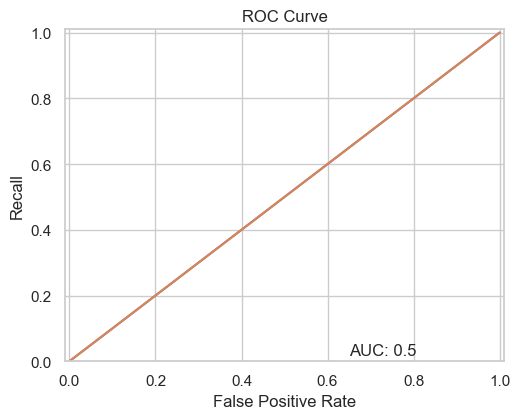

In [214]:
# We create a Dummy model

model = DummyClassifier(strategy='most_frequent')
model.fit(features_train_oheu, target_train_oheu)
dummy_predu = model.predict(features_test_oheu)

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= dummy_predu
)

fig.tight_layout(pad=3.0)
plt.show()

### DecissionTree Upsample

In [215]:
# We create our decissiontree model

param_grid = {
    'max_depth':[None,3,5,7,9,11],
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[2,4,6]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(
        random_state = random_state),
        param_grid=param_grid, 
        cv=5,
        scoring='roc_auc')

grid_search.fit(features_train_oheu, target_train_oheu)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_treeu = best_model.predict(features_test_oheu)

print(best_model)
print(best_params)
print(best_score)

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=8,
                       random_state=12345)
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8}
0.883553507367337


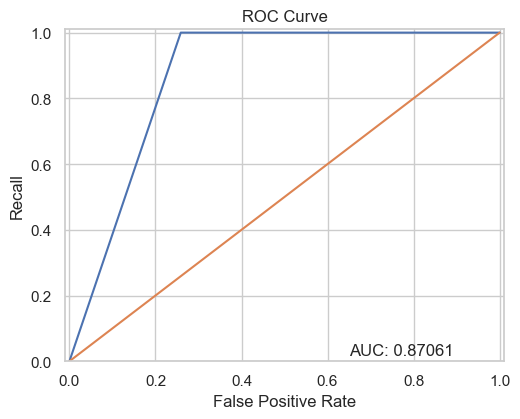

In [216]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= predict_treeu
)

fig.tight_layout(pad=3.0)
plt.show()

### RandomForest Upsample

In [217]:
# We create a random forest model

param_grid = {
    'n_estimators':[20,40,50,100],
    'max_depth':[None,3,5,7,9,11],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state = random_state), 
        param_grid=param_grid, cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_oheu, target_train_oheu)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_forestu = best_model.predict(features_test_oheu)

print(best_model)
print(best_params)
print(best_score)

RandomForestClassifier(random_state=12345)
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
0.9947767701675811


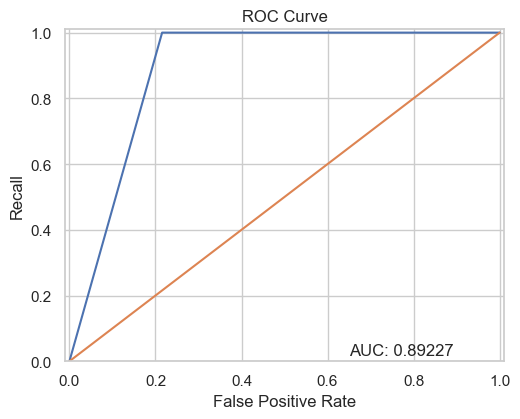

In [218]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= predict_forestu
)

fig.tight_layout(pad=3.0)
plt.show()

### LogisticRegression Upsample

In [219]:
# We create a Logistic Regression model

param_grid = {
     'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter = 5000, solver = 'liblinear'), 
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_oheu, target_train_oheu)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_lru = best_model.predict(features_test_oheu)

print(best_model)
print(best_params)
print(best_score)

LogisticRegression(C=0.1, max_iter=5000, solver='liblinear')
{'C': 0.1, 'penalty': 'l2'}
0.8382767412275538


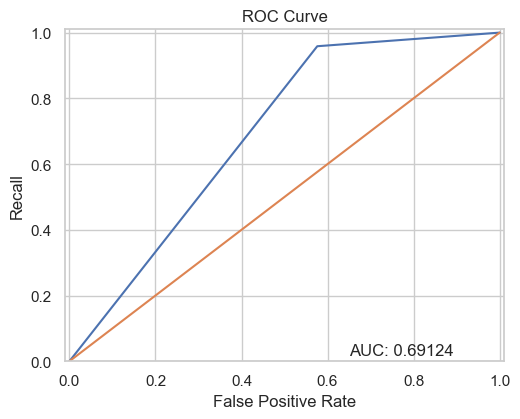

In [220]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= predict_lru
)

fig.tight_layout(pad=3.0)
plt.show()

#### LightGBM Upsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11914, number of negative: 3285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 15199, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.783867 -> initscore=1.288348
[LightGBM] [Info] Start training from score 1.288348


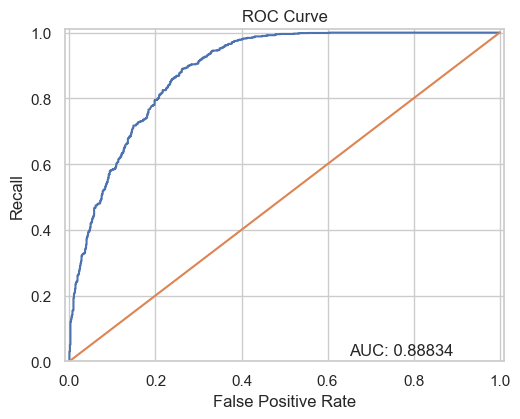

In [221]:
# We create our LGB model

train_data = lgb.Dataset(features_train_oheu,label=target_train_oheu)
test_data = lgb.Dataset(features_test_oheu,label=target_test_oheu)
params = {
    'objective': 'binary',  
    'metric': 'binary_logloss', 
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
num_round = 100
bts = lgb.train(params, train_data, num_round, valid_sets=[test_data])
lgb_predictu = bts.predict(features_test_oheu,num_iteration=bts.best_iteration)

# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= lgb_predictu
)

fig.tight_layout(pad=3.0)
plt.show()

#### CatBoost Upsample

In [222]:
# We create our CarBoost model

param_grid = {
     'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0),
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc')

grid_search.fit(features_train_oheu, target_train_oheu)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
predict_cbu = best_model.predict(features_test_oheu)

print(best_model)
print(best_params)
print(best_score)

{'depth': 8, 'learning_rate': 0.2, 'n_estimators': 200}
0.9509044878432714


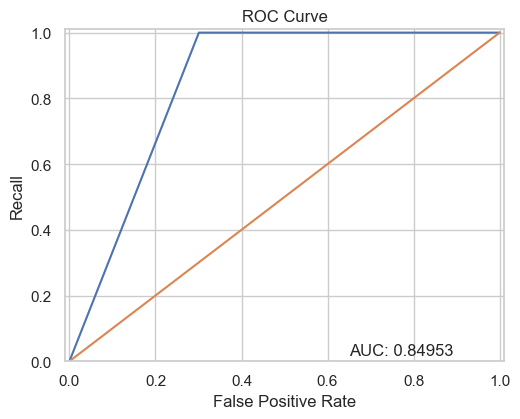

In [223]:
# We graph our output

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= predict_cbu
)

fig.tight_layout(pad=3.0)
plt.show()

#### Neural Network

Train on 15199 samples, validate on 3800 samples
Epoch 1/5
14848/15199 [============================>.] - ETA: 0s - loss: 2.1381 - acc: 0.7769

c:\Users\ZonaDigital\Documents\3. Repositorios\Triple-Ten\Sprint_17_Final_Project\venv\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


15199/15199 [==============================] - 1s 82us/sample - loss: 2.0983 - acc: 0.7781 - val_loss: 0.4030 - val_acc: 0.8300
Epoch 2/5
15199/15199 [==============================] - 1s 78us/sample - loss: 0.5633 - acc: 0.8040 - val_loss: 0.3989 - val_acc: 0.8289
Epoch 3/5
15199/15199 [==============================] - 1s 65us/sample - loss: 0.6240 - acc: 0.8012 - val_loss: 0.5507 - val_acc: 0.7703
Epoch 4/5
15199/15199 [==============================] - 1s 68us/sample - loss: 0.6581 - acc: 0.8044 - val_loss: 0.7372 - val_acc: 0.8053
Epoch 5/5
15199/15199 [==============================] - 1s 77us/sample - loss: 0.6064 - acc: 0.8084 - val_loss: 0.5291 - val_acc: 0.7826


c:\Users\ZonaDigital\Documents\3. Repositorios\Triple-Ten\Sprint_17_Final_Project\venv\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


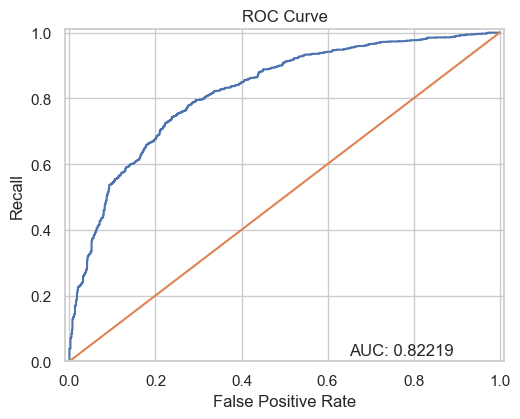

In [225]:
# We create a simple neural network model

model = Sequential()
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    features_train_oheu.values, target_train_oheu.values, epochs = 5, batch_size= 32,validation_data=(features_test_oheu.values, target_test_oheu.values))

neu_net_predict = model.predict(features_test_oheu.values)

# Graficamos nuestros resultados

fig, ax = plt.subplots(figsize=(6, 5))

plot_roc(
    custom_axis= ax,
    y= target_test_oheu,
    predictions= neu_net_predict
)

fig.tight_layout(pad=3.0)
plt.show()

**Conclutions Upsumple Models**

**Dummy**
- Roc_Auc: 0.5

**DecisionTree**
- Best Params: max_depth None, min_samples_leaf 2 min_samples_split 8
- Roc_Auc training: 0.883
- Roc_Auc test: 0.87

**RandomForest**
- Best Params: max_depth None, min_samples_leaf 2, n_estimators 100 
- Roc_Auc training: 0.994
- Roc_Auc test: 0.892

**LogisticRegression**
- Best Params: C 0.1, class_weight “Balanced”, max_iter 5000, penalty L2, solver “Liblinear”
- Roc_Auc training: 0.838
- Roc_Auc test: 0.691

**LightGBM**
- Params: 'objective': 'binary', 'metric': 'binary_logloss',  'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9
- Roc_Auc test: 0.888

**CatBoost**
- Best Params: depth 8, learning_rate 0.2, n_estimators 200
- Roc_Auc training: 0.95
- Roc_Auc test: 0.849

**Neural Network**
- Roc_Auc test: 0.79



By using the oversampling method in our dataset, we have achieved much better results in almost all our models. It's evident that the class imbalance was affecting our models. In nearly all models, we have achieved good results. The best model was the Random Forest with oversampling, achieving an ROC_AUC of 0.892 on the test set.